# Gene-Prediction-in-Metagenomics-Fragments
Written by: Vignesh Ravindranath, Shawn Huang

This project was based on the 2008 paper ['Gene prediction in metagenomic fragments: A large scale machine learning approach'](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-9-217) by Hoff et at. The purpose of the project is to gain a `deeper understanding of machine learning approaches behind the Orphelia gene prediction algorithm`. 
    
The project consists of several sections:
1. Helper Functions (preprocessing, orf-finder, find-interregions)
2. Preprocess Genome (extract coding sequences/non-coding sequences, shuffle/split data)
3. Extract Features (monocodon frequency, dicodon frequency, tis, gc)
3. Linear Discriminant - Dimentionality Reduction on monocodon/dicodon/tis
4. Binary classification neural network for coding/noncoding gene prediction
    
In the second section, high-dimensional features such as `monocodon (tricodon) usage`, `dicodon (hexcodon) usage`, and `translation initiation sites (TIS)` must be extracted from prokaryotic genomes. Monocodon and dicodon usage refer to the frequence of codons (3 basepairs) and dicodons (6 basepairs) in coding and noncoding regions. Coding proteins often have a TIS upstream of the start codon. These TIS patterns are extracted by comparing up and downstream regions for positive TIS candidates (true start codons in coding sequences) to negative TIS candidates (start codons in noncoding sequences).  
    
In the fourth section, linear discriminants are derived to reduce the dimensionality of the extracted features. The individual features (excluding GC content) are taken as multivariate linear regression problems and the Normal Equation is utilized to compute the weights (coefficient) matrix for each feature. 
    
In the last section, a neural network is trained on the reduced features mentioned above, in addition to the `GC content`.

    Summary of features:
    x1 - tricodon       - (n,64) 
    x2 - hexcodon       - (n,4096)
    x3 - TIS-pos        - (n,58,64 == n,3712)
    x4 - TIS-neg        - (n,58,64 == n,3712)
    x7 - GC content     - (n,1) column

In [1]:
import os
import sys
import pickle

import numpy as np
from scipy.sparse import csr_matrix
from tensorflow.keras.utils import to_categorical

import re
import itertools
import textwrap

from Bio import SeqIO
from Bio.SeqUtils import GC
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import SeqFeature, FeatureLocation

# Save/Load Data

In [2]:
def save(name, data):
    # check for data folder
    # check if file exists 
    filename = './data/' + name
    outfile = open(filename, 'wb')
    pickle.dump(data, outfile)
    outfile.close()
    print(f'Saved data to {filename}.')
    
def load(name):
    filename = './data/' + name
    infile = open(filename, 'rb')
    data = pickle.load(infile)
    infile.close()
    print(f'Loaded data from {filename}.')
    return data

# Helper Functions

## Preprocessing Genome Helper Function
Preprocessing a genome consists of extracting valid coding and noncoding sequences. Coding sequences are simply the genes themselves and serve as positive test samples. Noncoding sequences are open reading frames (ORFs) found in the interregions of a genome. These sequences start with a start codon and end with a stop codon, but they do not code for proteins - negative test samples. 

In [169]:
def preprocess_genome(seq_record, dna, OFFSET=30):
    # Get positive ORFs (coding sequences (CDS) or genes)
    l_min = 60 # ref: Hoff et al. paper
    cds = []
    for feature in seq_record.features:
        if feature.type == 'CDS':
            tag    = feature.qualifiers['locus_tag'][0]
            start  = feature.location.start.position
            end    = feature.location.end.position
            strand = feature.strand
            m30    = (dna[0][start-OFFSET:start] if strand == 1 else dna[1][::-1][end:end+OFFSET][::-1]).seq
            seq    = (dna[0][start:end] if strand == 1 else dna[1][::-1][start:end][::-1]).seq
            p30    = (dna[0][end:end+OFFSET] if strand == 1 else dna[1][::-1][start-OFFSET:start][::-1]).seq
            
            if len(seq) < l_min: continue # check if orf length > l_min = 60
            
            f = [SeqFeature(FeatureLocation(start, end, strand), type='CDS')]
            r = SeqRecord(m30+seq+p30, name=tag, id=prokaryote_id, features=f)            
            cds.append(r)
            
    # Find interregions
    interregions = get_interregions(cds)
    
    # Get negative ORFs(longest ORF in interregion)
    ## interregion (i or intr)
    ## longest orf (long)
    
    ncs = []
    for interregion in interregions:
        feature = interregion.features[0]
        strand  = feature.strand

        # find longest orf in interregion
        i_start  = feature.location.start.position
        i_end    = feature.location.end.position
        intr_seq = dna[0][i_start:i_end] if strand == 1 else dna[1][::-1][i_start:i_end][::-1]
        long_orf = longest_orf(intr_seq.seq)

        if not long_orf: continue                       # check if orf exists 
        if long_orf[1] - long_orf[0] < 60: continue  # check if orf length > l_min = 60

        tag   = interregion.name
        start = i_start + long_orf[0]
        end   = i_start + long_orf[1]

        m_start = start - OFFSET
        m_end = end + OFFSET
        
        m30   = (dna[0][m_start:start] if strand == 1 else dna[1][::-1][end-1:m_end-1][::-1]).seq
        seq   = intr_seq[long_orf[0]:long_orf[1]].seq
        p30   = (dna[0][end:m_end] if strand == 1 else dna[1][::-1][m_start-1:start-1][::-1]).seq
        
        f = [SeqFeature(FeatureLocation(start, end, strand), type='NCS')]
        r = SeqRecord(m30+seq+p30, name=tag, id=prokaryote_id, features=f)
        ncs.append(r)
    
    return cds, ncs

## Find Interregions Helper Function
Searches between genes (coding sequences) for interregion sequences.

In [2]:
# Copyright(C) 2009 Iddo Friedberg & Ian MC Fleming
# Released under Biopython license. http://www.biopython.org/DIST/LICENSE
# Do not remove this comment
def get_interregions(coding_records):
    cds_list_plus = []
    cds_list_minus = []
    intergenic_records = []
    
    initials = coding_records[0].name[0:2]
    prokaryote_id = seq_record.id

    # Loop over the genome file, get the CDS features on each of the strands
    for record in coding_records:
        feature = record.features[0]
        mystart = feature.location.start.position
        myend = feature.location.end.position
        if feature.strand == -1:
            cds_list_minus.append((mystart,myend,-1))
        elif feature.strand == 1:
            cds_list_plus.append((mystart,myend,1))
        else:
            sys.stderr.write("No strand indicated %d-%d. Assuming +\n" %(mystart, myend))
            cds_list_plus.append((mystart,myend,1))
    for i,pospair in enumerate(cds_list_plus[1:]):
        # Compare current start position to previous end position
        last_end = cds_list_plus[i][1]
        this_start = pospair[0]
        if this_start - last_end >= 1:
            intergene_seq = seq_record.seq[last_end:this_start]
            strand_string = +1
            name = initials + '_NC' + str(i).zfill(5)
            feature = [SeqFeature(FeatureLocation(last_end+1,this_start,strand_string), type='interregion')]
            intergenic_records.append(SeqRecord(intergene_seq, name=name, id=prokaryote_id, features=feature))
    buffer = i
    for i,pospair in enumerate(cds_list_minus[1:]):
        last_end = cds_list_minus[i][1]
        this_start = pospair[0]
        if this_start - last_end >= 1:
            intergene_seq = seq_record.seq[last_end:this_start]
            strand_string = -1
            name = initials + '_NC' + str(i+buffer).zfill(5)
            feature = [SeqFeature(FeatureLocation(last_end+1,this_start,strand_string), type='interregion')]
            intergenic_records.append(SeqRecord(intergene_seq, name=name, id=prokaryote_id, features=feature))
    return intergenic_records

## ORF Finder Helper Functions
Purpose is to find all valid ORFs in a given Bio.Seq.Seq sequence.

In [3]:
START_CODONS = ['ATG','CTG','GTG','TTG']
STOP_CODONS = ['TAG','TGA','TAA']

def _codon_pos(seq, codon_list):
    pos = []
    for codon in codon_list:
        matches = re.finditer(codon, str(seq))
        matches_positions = [match.start() for match in matches]
        pos.extend(matches_positions)
    return sorted(pos)

'''
Input: Bio.Seq.Seq
Output: returns start and end position of longest orf in a sequence
'''
def longest_orf(seq):
    all_starts = _codon_pos(seq, START_CODONS)
    all_stops  = _codon_pos(seq, STOP_CODONS)

    orfs = []
    found = False;            
    for s in all_starts:
        for e in all_stops[::-1]:
            if (e >= s) and ((e-s)%3 == 0):
                found = True; orfs = [s,e+3];
                break
        if found: break
            
    return orfs

'''
Input: Bio.Seq.Seq
Output: returns all in-frame start codons within an ORF sequence
'''
def orf_finder(orf_seq):
    all_starts = _codon_pos(orf_seq, START_CODONS)

    # find all ORF
    orfs = []
    e = len(orf_seq)
    for s in all_starts:
        if (e >= s) and (s%3 == 0):
            orfs.append([s,e])
    return orfs

## Fetch Genome Using Entrez

In [5]:
def fetch_genome(prokaryote_id):
    # seq_records (features) from GenBank file
    handle = Entrez.efetch(db="sequences", id=prokaryote_id, rettype="gbwithparts", retmode="text")
    seq_record = SeqIO.read(handle, "gb")
    handle.close()
    print(f'Fetched {prokaryote_id} GenBank sequence')

    # full sequence from FASTA file
    handle = Entrez.efetch(db="sequences", id=prokaryote_id, rettype="fasta", retmode="text")
    sequence = SeqIO.read(handle, "fasta")
    handle.close()
    print(f'Fetched {prokaryote_id} FASTA sequence')
    
    return seq_record, sequence

# Preprocess Genome

## Find CDS and NCS from Genome

In [7]:
from Bio import Entrez
Entrez.email = "vignesh.ravindranath@gmail.com"

# fetch genome
prokaryote_id = 'NC_000917'
seq_record, sequence = fetch_genome(prokaryote_id) 

# store coding, noncoding strands
dna = [sequence, sequence.reverse_complement()]

Fetched NC_000917 GenBank sequence
Fetched NC_000917 FASTA sequence


In [170]:
# preprocess genome 
%time _cds, _ncs = preprocess_genome(seq_record, dna)
print(f'{len(_cds)} CDS Records')
print(f'{len(_ncs)} NCS Records')

CPU times: user 9.33 s, sys: 31.2 ms, total: 9.36 s
Wall time: 9.35 s
2473 CDS Records
944 NCS Records


In [173]:
# save data
save('orfs', [_cds, _ncs])

Saved data to ./data/orfs.


## *Load CDS and NCS Data

In [3]:
# load data
_cds, _ncs = load('orfs')

print(f'{len(_cds)} CDS ORFs')
print(f'{len(_ncs)} NCS ORFs')

Loaded data from ./data/orfs.
2473 CDS ORFs
944 NCS ORFs


## *Suffle and Split Data
Positive (CDS) and negative (NCS) sequences will be split into linear discriminant training data (50%) and neural network training data (50%). 
- 50% Linear Discriminant (LD) training
- 40% NN Training
- 5% NN Validation
- 5% NN Testing

In [4]:
import random
random.seed(8)
random.shuffle(_cds)
random.shuffle(_ncs)

for i in range(5):
    print(_cds[i].name, _ncs[i].name)

AF_RS04145 AF_NC01437
AF_RS11540 AF_NC01750
AF_RS02565 AF_NC01308
AF_RS11405 AF_NC00093
AF_RS07390 AF_NC00403


In [5]:
a = int(len(_cds)/2)
b = int(len(_ncs)/2)

LD_Tis_Data = _cds[0:a]
LD_Cod_Data = _cds[0:a] + _ncs[0:b]
NN_Data = _cds[a:] + _ncs[b:]

print(f'LD Dataset: {len(LD_Tis_Data)}')
print(f'LD Dataset: {len(LD_Cod_Data)}')
print(f'NN Dataset: {len(NN_Data)}')

LD Dataset: 1236
LD Dataset: 1708
NN Dataset: 1709


# Extract Features Functions
Extracts monocodon frequency (tri), dicodon frequency (hex), translation initiation site (tis) information, and gc content.
- Monocodon Frequency: 64-size array with counts of each codon possibility in seq (AAA, AAC, ..., TTT)
- Dicodon Frequency: 4096-size array with counts of each dicodon possibility in seq (AAAAAA, AAAAAC, ..., TTTTTT)
- TIS: (64,58)-size matrix with codon occurance at each position. Position is centered about the start codon.
- GC Content: (count(G)+count(C))/len(seq)

## Codon Frequency Helper Functions

In [8]:
# Produces all tri/hex codon permutations 4^n (ex. AAA, AAC,...,TTT for n=3) 
def permutations_with_replacement(n):
    for i in itertools.product(("A", "C", "G", "T"), repeat=n):
        yield i

# Function to create codon:idx dictionary. Converts codons to integers (ex. {AAA:0, AAC:1, ..., TTT:63} for n=3)
def populate_codon_idx_dict(nbases=3):
    codon_idx_dict = {}
    count = 0
    for i in permutations_with_replacement(nbases):
        key = "".join(i) #codon or dicodon sequence
        codon_idx_dict[key] = count
        count += 1
    return codon_idx_dict


TRICODON_IDX_DICT = populate_codon_idx_dict(nbases=3)
HEXCODON_IDX_DICT = populate_codon_idx_dict(nbases=6)


# Parse dna sequence into a list of codons separated by nbases
# Input: Bio.Seq.Seq
'''
Ex. Input  - AAATTTGGG
    Output - ['AAA','TTT','GGG'] if nbases=3
           = ['AAATTT','TTTGGG'] if nbases=6
'''
def _codon_parser(seq, nbases):
    codon_seq = [seq[i:i+nbases] for i in range(0,len(seq),3) if (i+nbases)<len(seq)]
    return codon_seq

# Returns count of tri/hex codon frequencies in list form
# Input: Bio.Seq.Seq
def codon_frequency(seq, nbases):      
    codon_idx_dict = TRICODON_IDX_DICT if nbases==3 else HEXCODON_IDX_DICT
    frame = [0]*len(codon_idx_dict)
    
    parsed_codons = _codon_parser(seq, nbases)
    for codon in parsed_codons:
        frame[codon_idx_dict[codon]] += 1
    frame[codon_idx_dict[parsed_codons[-1]]] += 1 # add last codon
    
    return frame

# reference for unit Euclidean norm
# https://stackoverflow.com/questions/18524112/norm-along-row-in-pandas
def extract_codon_usage(seq, n):
    frame = codon_frequency(seq, n)
    frame_norm = frame / np.sqrt(np.sum(np.square(frame))) # faster than np.linalg.norm
    data = np.array(frame_norm)
    return data

## Extract Features

In [14]:
def extract_codon_features(orfs, train_nn=False, OFFSET=30):

    _tri, _hex, _gc, _yc = [], [], [], []
    _tis_nn = []
    
    for record in orfs:
        seq = record[OFFSET:-OFFSET].seq

        # MONOCODON FREQUENCE
        tri_data = extract_codon_usage(seq, 3)
        _tri.append(tri_data)
        
        # DICODON FREQUENCE
        hex_data = extract_codon_usage(seq, 6)
        _hex.append(hex_data)
        
        # TIS
        if train_nn:
            seq60 = record[0:(2*OFFSET)].seq
            frame = [TRICODON_IDX_DICT[seq60[i:i+3]] for i in range(0,len(seq60)-2)]
            tis_data = np.array(to_categorical(frame, num_classes=64).astype(int).reshape(-1))
            _tis_nn.append(tis_data)

        # GC
        gc_data = np.float16(GC(seq) / 100)
        _gc.append(gc_data)
        
        # Y
        typ = record.features[0].type
        if typ == 'CDS': _yc.append(1)
        else: _yc.append(-1)
        
    return np.array(_tri), np.array(_hex), np.array(_tis_nn), np.array(_gc), np.array(_yc)

In [10]:
def extract_tis_features(cds, OFFSET=30):
    _tis, _yt = [], []
    for record in cds:
        seq = record.seq
        
        # find orf-set
        orf_set = orf_finder(seq[OFFSET:-OFFSET])
        
        for i,cand in enumerate(orf_set):
            cand_start = cand[0] + OFFSET
            
            # find sequence window and populate codon information (58,) at each position
            seq60 = record[(cand_start-OFFSET):(cand_start+OFFSET)].seq 
            frame = [TRICODON_IDX_DICT[seq60[i:i+3]] for i in range(0,len(seq60)-2)]

            # convert frame to (58,64) using to_categorical and flatten to 1D array
            tis_data = np.array(to_categorical(frame, num_classes=64).astype(int).reshape(-1))
            
            _tis.append(tis_data)
            if i == 0: _yt.append(1)
            else: _yt.append(-1)
                
    return np.array(_tis), np.array(_yt)

# Linear Discriminant - Dimensionality Reduction

## Extract Features from LD_Data

In [180]:
# feature extraction

# codon features: tri, hex, tis_nn, gc, y
%time LD_tri, LD_hex, _, _, LD_yc = extract_codon_features(LD_Cod_Data, train_nn=False)

# tis features: tis, yt
%time LD_tis, LD_yt = extract_tis_features(LD_Tis_Data)

CPU times: user 3.31 s, sys: 156 ms, total: 3.47 s
Wall time: 3.47 s
CPU times: user 3.61 s, sys: 1.88 s, total: 5.48 s
Wall time: 5.49 s


In [181]:
# save data
save('LDFE', [LD_tri, LD_hex, LD_yc, LD_tis, LD_yt])

Saved data to ./data/LDFE.


## *Load LD_Data Extracted Features

In [3]:
# load data
LD_tri, LD_hex, LD_yc, LD_tis, LD_yt = load('LDFE')

Loaded data from ./data/LDFE.


## Minimize Linear Regression using Normal Equation

We need to minimize:

$$ E(w_M) = \frac{1}{n}\sum_{i=0}^{n}(w_m \cdot x_M^i - y_i)^2 + \lambda w_M \cdot w_M $$

where $x_M^i \in \mathbb{R}^{64}$ is the $i-th$ column of the monocodon frequency matrix $\textbf{X}_M$, $n=64$ monocodon possibilities, $y_M^i \in (-1, 1)$ is the $i-th$ element of the label vector, and $w_M$ is the discriminant weight vector.

We can minimize $E$ by:

$$w_M = (X_MX_M^T +\lambda n\textbf{I})^{-1}X_My_M$$

This can be generalized to train the discriminant vector $w$ for dicodon frequency and TIS. 

### Solve for Linear Discriminant Weight Vectors

In [182]:
'''
X (_,n), where n = 64, 4096, or 3712
'''
def train_linear_discriminant(X, y, l=1):    
    I = np.eye(X.shape[1])
    return np.linalg.inv(X.T@X + l*I) @ X.T@y

In [183]:
# LD_tri
XM = csr_matrix(LD_tri)
%time wM = train_linear_discriminant(XM, LD_yc)
wM = np.array(wM).reshape(-1)
wM.shape

CPU times: user 62.5 ms, sys: 0 ns, total: 62.5 ms
Wall time: 29.8 ms


(64,)

In [184]:
# LD_hex
XD = csr_matrix(LD_hex) 
%time wD = train_linear_discriminant(XD, LD_yc)
wD = np.array(wD).reshape(-1)
wD.shape

CPU times: user 11 s, sys: 1.55 s, total: 12.5 s
Wall time: 6.49 s


(4096,)

In [185]:
# LD_tis
XT = csr_matrix(LD_tis) 
%time wT = train_linear_discriminant(XT, LD_yt)
wT = np.array(wT).reshape(-1)
wT.shape

CPU times: user 9.73 s, sys: 2.08 s, total: 11.8 s
Wall time: 7.89 s


(3712,)

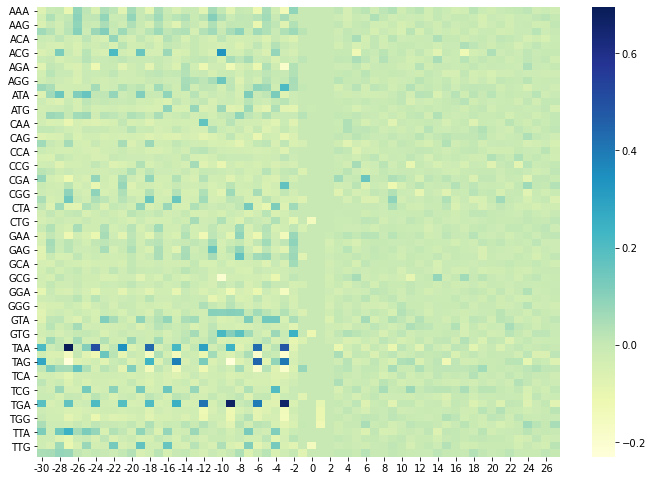

In [186]:
# visualize TIS patterns (up and downstream regions)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

w = np.array(wT).reshape(58,64).T

y_axis_labels = populate_codon_idx_dict().keys() 
x_axis_labels = [i for i in range(-30,28)]

df = pd.DataFrame(w, columns=x_axis_labels, index=y_axis_labels)

a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.heatmap(ax=ax, data=df, cmap="YlGnBu")

### Save Weights

In [187]:
# save data
save('weights', [wM, wD, wT])

Saved data to ./data/weights.


## *Fit Gaussian Distribution to TIS Feature

In [22]:
from scipy.stats import norm

def prior_gaussian(tis_pos, tis_neg):
    pos_y = len(tis_pos)
    neg_y = len(tis_neg)
    tis_y = pos_y + neg_y
    
    # prior probabilities
    pi_pos = pos_y/tis_y
    pi_neg = neg_y/tis_y

    # gaussian mean and sd
    mu_pos = np.mean(tis_pos)
    sd_pos = np.std(tis_pos)

    mu_neg = np.mean(tis_neg)
    sd_neg = np.std(tis_neg)

    return [pi_pos, pi_neg], [mu_pos, mu_neg], [sd_pos, sd_neg]
    
# returns probability that tis sequence is tis positive (from a gene) 
def X3(s, pi, mu, sd):
    likelihood = norm.pdf(s, mu[0], sd[0])
    marginal = pi[0]*norm.pdf(s, mu[0], sd[0]) + pi[1]*norm.pdf(s, mu[1], sd[1])
    
    return (pi[0] * likelihood) / marginal

# returns probability that tis sequence is tis negative (not from a gene)
def X4(s, pi, mu, sd):
    likelihood = norm.pdf(s, mu[1], sd[1])
    marginal = pi[0]*norm.pdf(s, mu[0], sd[0]) + pi[1]*norm.pdf(s, mu[1], sd[1])
    
    return (pi[1] * likelihood) / marginal

In [189]:
_, _, wT = load('weights')
LD_tis_red = LD_tis @ wT
LD_tis_red.shape

(27338,)

In [190]:
LD_tis_pos = []
LD_tis_neg = []

for element in zip(LD_tis_red, LD_yt):
    if element[1] == 1:
        LD_tis_pos.append(element[0])
    else:
        LD_tis_neg.append(element[0])
        
print(len(LD_tis_pos), len(LD_tis_neg))

1236 26102


### Save tis statistics

In [191]:
pi, mu, sd = prior_gaussian(LD_tis_pos, LD_tis_neg)
save('tis-stats', [pi, mu, sd])

print(pi)
print(mu)
print(sd)

Saved data to ./data/tis-stats.
[0.04521179310849367, 0.9547882068915063]
[0.16513664352450205, -0.9604509605631415]
[0.5368255912872503, 0.17466255691044522]


In [192]:
pos_test = LD_tis_pos[0]
neg_test = LD_tis_neg[0]
print(pos_test, neg_test)

0.4770622890779112 -0.5234222167192724


In [193]:
print(X3(pos_test, pi, mu, sd))
print(X4(pos_test, pi, mu, sd))

0.9999999999998498
1.5023254084523182e-13


In [194]:
print(X3(neg_test, pi, mu, sd))
print(X4(neg_test, pi, mu, sd))

0.13409676835181558
0.8659032316481844


# Binary Neural Network Classification

In [6]:
from keras.models import Sequential
from keras.layers import Dense

## Extract Features from NN_Data

In [15]:
# feature extraction

# codon features: tri, hex, tis_nn, gc, y
%time NN_tri, NN_hex, NN_tis, NN_gc, NN_y = extract_codon_features(NN_Data, train_nn=True)

CPU times: user 3.92 s, sys: 281 ms, total: 4.2 s
Wall time: 4.18 s


In [16]:
# save data
save('NNFE', [NN_tri, NN_hex, NN_tis, NN_gc, NN_y])

Saved data to ./data/NNFE.


## Load NN_Data Extracted Features

In [20]:
# load data
wM, wD, wT = load('weights')
pi, mu, sd = load('tis-stats')
NN_tri, NN_hex, NN_tis, NN_gc, NN_y = load('NNFE')

Loaded data from ./data/weights.
Loaded data from ./data/tis-stats.
Loaded data from ./data/NNFE.


## Reduce Features

In [23]:
x1 = NN_tri @ wM
x2 = NN_hex @ wD 
x3 = X3(NN_tis @ wT, pi, mu, sd)
x4 = X4(NN_tis @ wT, pi, mu, sd)
x7 = NN_gc
y  = NN_y

print(x1.shape, x2.shape, x3.shape, x4.shape, x7.shape, y.shape)

(1709,) (1709,) (1709,) (1709,) (1709,) (1709,)


In [30]:
nn_data = np.stack((x1,x2,x3,x4,x7,y)).T

random.seed(8)
random.shuffle(nn_data)

X = nn_data[:, :-1]
y = nn_data[:, -1]

print(X.shape, y.shape)

(1709, 5) (1709,)


In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

## Define model

In [34]:
model = Sequential()
model.add(Dense(8, input_dim=5, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## Train NN

In [35]:
history = model.fit(X_train, y_train, epochs=100, batch_size=64)

Epoch 1/100
17/17 [==============================] - 0s 1ms/step - loss: 0.5094 - accuracy: 0.9483
Epoch 2/100
17/17 [==============================] - 0s 1ms/step - loss: 0.4662 - accuracy: 0.9571
Epoch 3/100
17/17 [==============================] - 0s 1ms/step - loss: 0.4241 - accuracy: 0.9571
Epoch 4/100
17/17 [==============================] - 0s 1ms/step - loss: 0.3830 - accuracy: 0.9571
Epoch 5/100
17/17 [==============================] - 0s 1ms/step - loss: 0.3437 - accuracy: 0.9571
Epoch 6/100
17/17 [==============================] - 0s 1ms/step - loss: 0.3058 - accuracy: 0.9571
Epoch 7/100
17/17 [==============================] - 0s 1ms/step - loss: 0.2705 - accuracy: 0.9571
Epoch 8/100
17/17 [==============================] - 0s 1ms/step - loss: 0.2369 - accuracy: 0.9571
Epoch 9/100
17/17 [==============================] - 0s 1ms/step - loss: 0.2059 - accuracy: 0.9571
Epoch 10/100
17/17 [==============================] - 0s 1ms/step - loss: 0.1757 - accuracy: 0.9571
Epoch 11/

In [36]:
y_pred = model.predict(X_test)

#Converting predictions to label
pred = []
for i in range(len(y_pred)):
    pred.append(np.argmax(y_pred[i]))

#Converting one hot encoded test label to label
test = []
for i in range(len(y_test)):
    test.append(np.argmax(y_test[i]))

In [37]:
from sklearn.metrics import accuracy_score
a = accuracy_score(pred, test)
print('Accuracy is:', a*100)

Accuracy is: 100.0
